In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


Inspect Data

In [7]:
landed = pd.read_csv("data\LandedArea.csv")
apartments = pd.read_csv('data\ApartmentsandCondos.csv')

resale_registration_1 = pd.read_csv("data/resale-flat-prices_HDB/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
resale_registration_2 = pd.read_csv("data/resale-flat-prices_HDB/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
resale_registration_3 = pd.read_csv("data/resale-flat-prices_HDB/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

resale_approval_1 = pd.read_csv("data/resale-flat-prices_HDB/resale-flat-prices-based-on-approval-date-1990-1999.csv")
resale_approval_2 = pd.read_csv("data/resale-flat-prices_HDB/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")

A look of resale by registration

In [8]:
resale_registration_1.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,52203.000000,52203.000000,5.220300e+04
mean,96.203285,1989.512902,4.612147e+05
std,24.984010,10.139550,1.225534e+05
min,31.000000,1966.000000,1.950000e+05
25%,73.000000,1983.000000,3.700000e+05
50%,95.000000,1988.000000,4.400000e+05
75%,111.000000,1999.000000,5.250000e+05
max,266.000000,2012.000000,1.088888e+06


It seems like the 3 dataset have the same price so we append them and then write to a final csv, for a better representation of the data

In [11]:
## Append works. So we write to a csv
resale_registration_full.to_csv("data/resale-flat-prices_HDB/resale-on-registration-full.csv")

In [13]:
resale_approval_full = resale_approval_1
resale_approval_full = resale_approval_full.append(resale_approval_2)
print(resale_approval_full.shape)
print(resale_approval_1.shape[0] + resale_approval_2.shape[0])
resale_approval_full.to_csv("data/resale-flat-prices_HDB/resale-on-approval-full.csv", index=False)

(656851, 10)
656851


In [3]:
resale_approval_full = pd.read_csv("data/resale-flat-prices_HDB/resale-on-approval-full.csv")

In [4]:
resale_approval_full.tail(7)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
656844,2012-02,YISHUN,5 ROOM,161,YISHUN ST 11,10 TO 12,121.0,Improved,1985,465000.0
656845,2012-02,YISHUN,5 ROOM,161,YISHUN ST 11,04 TO 06,121.0,Improved,1985,503000.0
656846,2012-02,YISHUN,5 ROOM,212,YISHUN ST 21,10 TO 12,121.0,Improved,1985,476888.0
656847,2012-02,YISHUN,5 ROOM,758,YISHUN ST 72,01 TO 03,122.0,Improved,1986,490000.0
656848,2012-02,YISHUN,5 ROOM,873,YISHUN ST 81,01 TO 03,122.0,Improved,1988,488000.0
656849,2012-02,YISHUN,EXECUTIVE,664,YISHUN AVE 4,07 TO 09,181.0,Apartment,1992,705000.0
656850,2012-02,YISHUN,EXECUTIVE,293,YISHUN ST 22,04 TO 06,163.0,Apartment,1992,630000.0


In [6]:
resale_registration_full = pd.read_csv("data/resale-flat-prices_HDB/resale-on-registration-full.csv", index_col=0)
resale_registration_full.tail(7)

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
68154,866,Improved,5 ROOM,122.0,1988,2020-02,67 years,490000.0,10 TO 12,YISHUN ST 81,YISHUN
68155,356,Apartment,EXECUTIVE,145.0,1988,2020-02,67 years 06 months,584000.0,07 TO 09,YISHUN RING RD,YISHUN
68156,355,Maisonette,EXECUTIVE,146.0,1988,2020-02,67 years 09 months,620000.0,01 TO 03,YISHUN RING RD,YISHUN
68157,792,Apartment,EXECUTIVE,147.0,1987,2020-02,66 years 06 months,570000.0,10 TO 12,YISHUN RING RD,YISHUN
68158,618,Apartment,EXECUTIVE,164.0,1992,2020-02,71 years 04 months,690000.0,01 TO 03,YISHUN RING RD,YISHUN
68159,611,Apartment,EXECUTIVE,142.0,1987,2020-02,66 years 09 months,505000.0,01 TO 03,YISHUN ST 61,YISHUN
68160,827,Maisonette,EXECUTIVE,145.0,1987,2020-02,66 years 08 months,630000.0,01 TO 03,YISHUN ST 81,YISHUN


### Data Processing

In [3]:
## Import necessary ML functions/modules
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer

In [4]:
## A function that would be flexible enough to transform categorical datasets.
## Note: Some preprocessing probably needs to be done, to convert some string variables to float

def process_data(df: pd.DataFrame, lb_cols: list=[], le_cols:list =[]) -> pd.DataFrame:
    ''' Args
    df - the data frame to process. Should be a pd.DataFrame
    lb_cols - columns to apply label binarizing to. Uses sklearn's LabelBinarizer. 
    le_cols - columns to apply label encoding to. Uses sklearn's LabelEncoder. 
    
    Note: le_cols is good for ordinal data while lb_cols is used similar to one-hot
    '''
    final_df = df.copy()
    lb = LabelBinarizer()
    for lb_col in lb_cols:
        lb.fit(df[lb_col])
        to_merge_df = pd.DataFrame(lb.transform(df[lb_col]), columns=lb.classes_)
        final_df = pd.merge(final_df, to_merge_df, left_index=True, right_index=True)
    
    final_df= final_df.drop(lb_cols, axis=1)
    
    le = LabelEncoder()
    for le_col in le_cols:
        le.fit(df[lb_col])
        final_df[le_col] = le.fit_transform(final_df[le_col])
        
    return final_df


Preprocessing resale_registration_full

In [5]:
## Analysis using resale_registration_full
## 1. Process data
resale_registration_full = pd.read_csv("data/resale-flat-prices_HDB/resale-on-registration-full.csv", index_col=0)
resale_registration_full = resale_registration_full.fillna(0)

def convert_remaining_lease(s):
    if s == 0:
        return 0
    elif type(s) == float:
        return s
    elif type(s) == str:
        list_s = s.split(' ')
        if len(list_s) == 2:  ## X years
            return int(list_s[0])
        elif len(list_s) == 4:  ## X years Y months
            return(int(list_s[0]) + float(list_s[2]))
        elif len(list_s) == 1:  ## 78
            return(float(s))
    elif type(s == int):
        return float(s)
    raise Exception(f"Weird remaining_lease format: {s}, type: {type(s)}")
            
def to_lower_alpha(s:str):
    return(s.lower())

def months_since2012(s:str):
    ## months are in this format: YYYY-MM
    YYMM =s.split('-')
    return (12 * (int(YYMM[0]) - 2012) + (int(YYMM[1]))) 
        
resale_registration_full['flat_model'] = resale_registration_full['flat_model'].apply(to_lower_alpha)
resale_registration_full['remaining_lease'] = resale_registration_full['remaining_lease'].apply(convert_remaining_lease)
resale_registration_full['month'] = resale_registration_full['month'].apply(months_since2012)

lb_cols = ["flat_model", "flat_type", "town", "street_name"]
le_cols = ["storey_range"]
resale_registration_full = process_data(resale_registration_full, lb_cols, le_cols)

assert resale_registration_full.shape == (157517, 606)

# resale_registration_fullX = resale_registration_full.reset_index(drop=True)
X = resale_registration_full.drop(['resale_price','block'], axis=1)
y = resale_registration_full['resale_price']

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
## Split into train and test -- to used later during model fitting
def split_df(X, y, month_threshold=80):
    X_train = X[X['month'] <= month_threshold]
    X_test = X[X['month'] > month_threshold]
    y_train = y.iloc[:X_train.shape[0]]
    y_test = y.iloc[X_train.shape[0]:]
    X_train = X_train.reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_df(X, y)

Preprocessing data on resale_approval_full

In [7]:
def commence_date_to_remaining(year: int):
    import datetime
    return 99 - (datetime.datetime.now().year - year)

## using process_data() on resale_approval_full
resale_approval_full = pd.read_csv("data/resale-flat-prices_HDB/resale-on-approval-full.csv")
resale_approval_full['month'] = resale_approval_full['month'].apply(months_since2012)
resale_approval_full['lease_remaining'] = resale_approval_full['lease_commence_date'].apply(commence_date_to_remaining)
resale_approval_full = resale_approval_full.drop(["block", "lease_commence_date"], axis=1)

lb_cols = ["flat_model", "street_name", "town"]
le_cols = ["flat_type", "storey_range"]
X_approval = process_data(resale_approval_full, lb_cols= lb_cols, le_cols=le_cols)
resale_approval_full.columns

Index(['month', 'town', 'flat_type', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'resale_price', 'lease_remaining'],
      dtype='object')

### Model fitting - ML Techniques

In [8]:
## functions to fit ML_models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.model_selection import GridSearchCV

## code is in housing/ML.py
from housing.ML import ML_Model

In [9]:
## ML techniques - Lasso
lasso = Lasso()
lasso_model = ML_Model(lasso, X, y, split_df)
lasso_model.fit()
lasso_model.predict()
lasso_model.get_metrics()
# lasso.fit(X_train,y_train)
# print(lasso.score(X_train, y_train))

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44690658377430.25, tolerance: 237513141318.42807
  positive)


Adding some metrics: mse, R_squared, Explained variance
{'MSE': 20094647916.15412, 'Explained Variance': 0.05792120689732261, 'R^2': 0.05705361836435108, 'MAE': 104636.60118171675}


In [10]:
## ML techniques - Bayesian Ridge
br = BayesianRidge()
br_model = ML_Model(br, X, y, split_df)
br_model.fit()
br_model.predict()
br_model.get_metrics()

Adding some metrics: mse, R_squared, Explained variance
{'MSE': 19813117567.9257, 'Explained Variance': 0.07078195564484402, 'R^2': 0.07026450040071675, 'MAE': 103872.2911893091}


RFC - it takes really long to run this so I haven't

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_train,y_train)
print(rfr.score(X_train, y_train))

Rolling predictions

build models with data on year $n$ to predict data on year $n+1$. We concat all predicted values.

In [11]:
lasso_model.rolling_predict(12)

(21475, 604) (21475,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3199739449023.881, tolerance: 30122662276.7243
  positive)


(15773, 604) (15773,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2488692220015.5215, tolerance: 25270152746.68449
  positive)


(16344, 604) (16344,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9377698652294.684, tolerance: 25790785426.024006
  positive)


(18166, 604) (18166,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67533020485503.06, tolerance: 32108991163.677063
  positive)


(19411, 604) (19411,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81578532404.84375, tolerance: 38393537275.35498
  positive)


(20472, 604) (20472,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7089870792559.469, tolerance: 47660145858.05213
  positive)


(22246, 604) (22246,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584145554923.3125, tolerance: 54322059957.31073
  positive)


Adding some metrics: mse, R_squared, Explained variance


In [12]:
lasso_model.get_metrics()

{'MSE': 20094647916.15412, 'Explained Variance': 0.05792120689732261, 'R^2': 0.05705361836435108, 'MAE': 104636.60118171675, '(Rolling mean) MAE': 67371.65460751504, '(Rolling mean) MSE': 8973238101.097103, '(Rolling mean) R^2': 0.2781672652508492, '(Rolling mean) Explained Variance': 0.26178754793839254}


In [13]:
lasso_model.rolling_predict(6)
lasso_model.get_metrics()

(12485, 604) (12485,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1681488515980.4697, tolerance: 16608702627.554735
  positive)


(8990, 604) (8990,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1394499420665.751, tolerance: 13407152839.874437
  positive)


(8664, 604) (8664,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 903635996216.0918, tolerance: 13938844209.473019
  positive)


(7109, 604) (7109,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 741946167034.56, tolerance: 11145195032.706993
  positive)


(8380, 604) (8380,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1765486292658.1147, tolerance: 12798881549.45043
  positive)


(7964, 604) (7964,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 936104068123.6875, tolerance: 12962152064.47683
  positive)


(9401, 604) (9401,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32396631594136.26, tolerance: 16311947981.599129
  positive)


(8765, 604) (8765,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31098225085549.01, tolerance: 15795494627.90496
  positive)


(10602, 604) (10602,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42365433111318.12, tolerance: 20630544876.908737
  positive)


(8809, 604) (8809,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1657483970634.7656, tolerance: 17762922046.672375
  positive)


(10986, 604) (10986,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13763857184231.688, tolerance: 24681564339.995434
  positive)


(9486, 604) (9486,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3090521251412.1875, tolerance: 22973991694.040928
  positive)


(12144, 604) (12144,)
(10102, 604) (10102,)


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660899468805.0625, tolerance: 24034015073.95807
  positive)


(11717, 604) (11717,)
Adding some metrics: mse, R_squared, Explained variance
{'MSE': 20094647916.15412, 'Explained Variance': 0.05792120689732261, 'R^2': 0.05705361836435108, 'MAE': 104636.60118171675, '(Rolling mean) MAE': 62715.11415974779, '(Rolling mean) MSE': 8246972046.424003, '(Rolling mean) R^2': 0.3635206861364498, '(Rolling mean) Explained Variance': 0.36048740456647604}


c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3806732153948.297, tolerance: 28043823145.61684
  positive)


It seems that rolling predictions work better. This might likely be due to structural information that 
might be lost but persisted in the future due to models taking averages over the whole time period to
minimise loss functions.

### Explained Variance
Lasso on processed resale_registration_full : 0.05792120689732261

Bayesian Ridge on processed resale_registration_full : 0.07078195564484402

Rolling predictions, Lasso on processed resale_registration_full : 0.2625062541461246

Rolling predictions,Bayesian Ridge on processed resale_registration_full : 



### Deep Learning Techniques

#### ANN

In [15]:
X_train, X_test, y_train, y_test = split_df(X, y)
df = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(16)
# for feat, targ in df.take(5):
#   print ('Features: {}, Target: {}'.format(feat, targ))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])
model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae', 'mse'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               77440     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 86,357
Trainable params: 86,357
Non-trainable params: 0
_________________________________________________________________


In [17]:
EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)

Train on 99328 samples, validate on 24832 samples
Epoch 1/100
99328/99328 - 11s - loss: 26822138366.6804 - mae: 117333.6562 - mse: 26822150144.0000 - val_loss: 19306000658.6392 - val_mae: 108330.2031 - val_mse: 19305998336.0000
Epoch 2/100
99328/99328 - 10s - loss: 10210779513.6907 - mae: 72519.3359 - mse: 10210778112.0000 - val_loss: 25677464936.4948 - val_mae: 122406.4141 - val_mse: 25677461504.0000
Epoch 3/100
99328/99328 - 10s - loss: 8722616750.1856 - mae: 66338.1641 - mse: 8722622464.0000 - val_loss: 25838952521.2371 - val_mae: 121450.2969 - val_mse: 25838956544.0000
Epoch 4/100
99328/99328 - 10s - loss: 8370510096.7423 - mae: 65280.2266 - mse: 8370511872.0000 - val_loss: 25809805947.5464 - val_mae: 121576.8750 - val_mse: 25809799168.0000
Epoch 5/100
99328/99328 - 10s - loss: 8151257794.7217 - mae: 64471.9336 - mse: 8151251456.0000 - val_loss: 25628049442.6392 - val_mae: 121626.7656 - val_mse: 25628061696.0000
Epoch 6/100
99328/99328 - 10s - loss: 8016004370.9691 - mae: 63951.535

Epoch 48/100
99328/99328 - 11s - loss: 6110940308.6186 - mae: 52900.7773 - mse: 6110944256.0000 - val_loss: 30736287227.7113 - val_mae: 131979.7500 - val_mse: 30736300032.0000
Epoch 49/100
99328/99328 - 11s - loss: 6092094646.7835 - mae: 52763.0352 - mse: 6092100096.0000 - val_loss: 31804368640.3299 - val_mae: 134609.9219 - val_mse: 31804401664.0000
Epoch 50/100
99328/99328 - 11s - loss: 6080424666.4330 - mae: 52710.5430 - mse: 6080423424.0000 - val_loss: 31502715848.1649 - val_mae: 133844.7656 - val_mse: 31502729216.0000
Epoch 51/100
99328/99328 - 10s - loss: 6063836526.4742 - mae: 52614.6875 - mse: 6063840768.0000 - val_loss: 31606513698.0619 - val_mae: 133345.9531 - val_mse: 31606530048.0000
Epoch 52/100
99328/99328 - 10s - loss: 6046874725.3608 - mae: 52468.2070 - mse: 6046878208.0000 - val_loss: 30774963328.4948 - val_mae: 131702.2031 - val_mse: 30774972416.0000
Epoch 53/100
99328/99328 - 10s - loss: 6029732275.1134 - mae: 52356.1758 - mse: 6029735424.0000 - val_loss: 30128614815.

Epoch 95/100
99328/99328 - 7s - loss: 5487305980.4948 - mae: 48984.6289 - mse: 5487310848.0000 - val_loss: 29869519359.1753 - val_mae: 128774.6719 - val_mse: 29869518848.0000
Epoch 96/100
99328/99328 - 7s - loss: 5470660550.8247 - mae: 48812.4062 - mse: 5470660608.0000 - val_loss: 31220181426.3093 - val_mae: 132404.0469 - val_mse: 31220183040.0000
Epoch 97/100
99328/99328 - 7s - loss: 5474408253.8969 - mae: 48880.7266 - mse: 5474402816.0000 - val_loss: 30146758356.9485 - val_mae: 129335.6250 - val_mse: 30146768896.0000
Epoch 98/100
99328/99328 - 8s - loss: 5464859912.9897 - mae: 48836.5586 - mse: 5464859648.0000 - val_loss: 30931341974.1031 - val_mae: 131213.7031 - val_mse: 30931333120.0000
Epoch 99/100
99328/99328 - 10s - loss: 5454236464.0619 - mae: 48678.8750 - mse: 5454239232.0000 - val_loss: 32282619020.7835 - val_mae: 133965.0781 - val_mse: 32282617856.0000
Epoch 100/100
99328/99328 - 7s - loss: 5452008378.4124 - mae: 48684.2422 - mse: 5452008960.0000 - val_loss: 32122065539.2165

In [18]:
## save model
model.save_weights("./checkpoints/ann-epoch-100")

In [20]:
## prediction
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
print(mean_squared_error(y_pred, y_test))
print(mean_absolute_error(y_pred, y_test))
print(explained_variance_score(y_pred, y_test))

22509405236.107265
107906.52360259842
-0.5796333655503159


### Time-series

Using a subset of data (certain street), we try to model data as a time-series, 
hopefully it'll improve eval metrics  

**Exogeneous Variables**

These are variables that would be similar throughout the time series and values dont change with time

- storey_range
- floor_area_sqm
- flat_model
- flat_type
- lease_commence_date -> remaining_lease

**Problems:**

We need one model per flat, which takes up alot of storage space and 
having so many models might be inefficient

In [26]:
time_series_registration = pd.read_csv("data/resale-flat-prices_HDB/resale-on-approval-full.csv")
time_series_registration.drop_duplicates(inplace=True)
time_series_registration["lease_remaining"] = time_series_registration["lease_commence_date"].apply(commence_date_to_remaining)
time_series_registration["flat_model"] = time_series_registration["flat_model"].apply(lambda x: x.lower())
time_series_registration.drop("lease_commence_date", axis=1, inplace=True)
print(time_series_registration.columns)
time_series_registration.shape

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'resale_price', 'lease_remaining'],
      dtype='object')


(655512, 10)

1. Lag the values

In [27]:
time_series_registration.sort_values(by=["street_name", "block", "month", "storey_range"], inplace=True)
sorted_time_series = time_series_registration.reset_index(drop=True)
sorted_time_series["last_resale_price"] = sorted_time_series["resale_price"].shift(1)
sorted_time_series.dropna(inplace=True)
sorted_time_series

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,lease_remaining,last_resale_price
1,2004-07,SEMBAWANG,5 ROOM,353A,ADMIRALTY DR,07 TO 09,110.0,improved,294000.0,81,325000.0
2,2005-01,SEMBAWANG,4 ROOM,353A,ADMIRALTY DR,13 TO 15,93.0,model a,255000.0,81,294000.0
3,2005-09,SEMBAWANG,4 ROOM,353A,ADMIRALTY DR,07 TO 09,93.0,model a,253000.0,81,255000.0
4,2005-09,SEMBAWANG,4 ROOM,353A,ADMIRALTY DR,13 TO 15,93.0,model a,244000.0,81,253000.0
5,2005-09,SEMBAWANG,4 ROOM,353A,ADMIRALTY DR,13 TO 15,93.0,model a,250000.0,81,244000.0
...,...,...,...,...,...,...,...,...,...,...,...
655507,2004-08,BUKIT MERAH,3 ROOM,91,ZION RD,10 TO 12,59.0,improved,170000.0,61,187000.0
655508,2004-09,BUKIT MERAH,3 ROOM,91,ZION RD,13 TO 15,59.0,improved,176000.0,61,170000.0
655509,2005-08,BUKIT MERAH,3 ROOM,91,ZION RD,04 TO 06,67.0,improved,202000.0,61,176000.0
655510,2005-09,BUKIT MERAH,3 ROOM,91,ZION RD,13 TO 15,59.0,improved,180000.0,61,202000.0


In [28]:
sorted_time_series["month"] = sorted_time_series["month"].apply(lambda x: int(x[:4])*12 + int(x[-2:])-1)
sorted_time_series.drop(["block", "town"],axis=1, inplace=True)
lb_cols = ["street_name", "flat_type", "flat_model"]
le_cols=["storey_range"]
ts_df = process_data(sorted_time_series,lb_cols=lb_cols, le_cols=le_cols)
ts_df.head(10)

,month,storey_range,floor_area_sqm,resale_price,lease_remaining,last_resale_price,ADMIRALTY DR,ADMIRALTY LINK,AH HOOD RD,ALEXANDRA RD,...,model a,model a-maisonette,model a2,multi generation,new generation,premium apartment,premium maisonette,simplified,standard,terrace
1,24054,2,110.0,294000.0,81,325000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,24060,4,93.0,255000.0,81,294000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,24068,2,93.0,253000.0,81,255000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,24068,4,93.0,244000.0,81,253000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,24068,4,93.0,250000.0,81,244000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,24069,2,110.0,310000.0,81,250000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,24069,3,93.0,244000.0,81,310000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,24071,4,93.0,245000.0,81,244000.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,24073,1,93.0,250000.0,81,245000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,24073,2,110.0,311000.0,81,250000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# np.amax(ts_df.month) ##24145
# np.amin(ts_df.month)  ## 23880
X = ts_df.drop("resale_price", axis=1)
y = ts_df["resale_price"]
# X_train, X_test, y_train, y_test = split_df(X, y, month_threshold=24110)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [30]:
def tf_split(X, y):
    return split_df(X,y, month_threshold=24110)

br = BayesianRidge()
br_model = ML_Model(br, X, y, tf_split)
br_model.fit()
br_model.predict()
br_model.get_metrics()

Adding some metrics: mse, R_squared, Explained variance
{'MSE': 15768776911.158035, 'Explained Variance': -0.5954210504417528, 'R^2': -0.6056233903565931, 'MAE': 100481.18267924953}


In [31]:
br_model.rolling_predict(12)

(12175, 563) (12175,)
(12736, 563) (12736,)
(14389, 563) (14389,)
(19602, 563) (19602,)
(25735, 563) (25735,)
(28443, 563) (28443,)
(34086, 563) (34086,)
(32066, 563) (32066,)
(52830, 563) (52830,)
(55198, 563) (55198,)
(35192, 563) (35192,)
(38551, 563) (38551,)
(35359, 563) (35359,)
(28924, 563) (28924,)
(29179, 563) (29179,)
(29298, 563) (29298,)
(27639, 563) (27639,)
(26955, 563) (26955,)
(26952, 563) (26952,)
(31263, 563) (31263,)
(34123, 563) (34123,)
(21692, 563) (21692,)
Adding some metrics: mse, R_squared, Explained variance


In [32]:
br_model.get_metrics()

{'MSE': 15768776911.158035, 'Explained Variance': -0.5954210504417528, 'R^2': -0.6056233903565931, 'MAE': 100481.18267924953, '(Rolling mean) MAE': 25000.00606635096, '(Rolling mean) MSE': 1226947852.25971, '(Rolling mean) R^2': 0.8809032025415567, '(Rolling mean) Explained Variance': 0.8329001530126152}


### Using URA's data
LandedArea.csv<br></br>ApartmentsandCondos.csv

In [5]:
landed.head()

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqft),Type of Area,Floor Level,Unit Price ($psf),Date of Sale
0,1,ONE TREE HILL COLLECTION,JALAN KELAWAR,Detached,10,CCR,Freehold,New Sale,1.0,15500000.0,-,5145.0,Land,-,3013.0,Feb-20
1,2,BAN GUAN PARK,HOLLAND ROAD,Detached,10,CCR,Freehold,Resale,1.0,15500000.0,-,9050.0,Land,-,1713.0,Feb-20
2,3,LANDED HOUSING DEVELOPMENT,CORONATION ROAD WEST,Detached,10,CCR,Freehold,Resale,1.0,9380000.0,-,6242.0,Land,-,1503.0,Feb-20
3,4,LANDED HOUSING DEVELOPMENT,JALAN AMPANG,Semi-detached,10,CCR,Freehold,Resale,1.0,6600000.0,-,4529.0,Land,-,1457.0,Feb-20
4,5,LANDED HOUSING DEVELOPMENT,JALAN JAMBU AYER,Detached,21,RCR,Freehold,Resale,1.0,8600000.0,-,6218.0,Land,-,1383.0,Feb-20


In [9]:
landed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 16 columns):
S/N                  843 non-null object
Project Name         848 non-null object
Street Name          837 non-null object
Type                 837 non-null object
Postal District      837 non-null object
Market Segment       837 non-null object
Tenure               837 non-null object
Type of Sale         836 non-null object
No. of Units         836 non-null float64
Price ($)            836 non-null float64
Nett Price ($)       836 non-null object
Area (Sqft)          836 non-null float64
Type of Area         836 non-null object
Floor Level          836 non-null object
Unit Price ($psf)    836 non-null float64
Date of Sale         836 non-null object
dtypes: float64(4), object(12)
memory usage: 106.8+ KB


In [6]:
# Running testing for landed since its sample size is smaller
landed_sfp = landed[['Type', 'Area (Sqft)', 'Unit Price ($psf)']]
landed_sfp = landed_sfp.dropna()
landed_sfp = pd.pivot_table(landed_sfp, values='Unit Price ($psf)', 
                     index=['Type'], 
                     columns='Area (Sqft)')
landed_sfp = landed_sfp.fillna(0)
landed_sfp.tail()

Area (Sqft),1489.0,1491.0,1496.0,1530.0,1532.0,1579.0,1615.0,1628.0,1640.0,1643.0,...,27829.0,29710.0,29955.0,30420.0,31211.0,36883.0,39228.0,43927.0,52059.0,66453.0
Type,,,,,,,,,,,,,,,,,,,,,
Detached,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,858.0,1548.0,1335.0,1430.0,1310.0,1000.0,1117.0,1309.0,1804.0,3281.0
Semi-detached,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Terrace,1511.0,1509.0,1521.0,1242.0,1815.0,1932.0,2294.583333,1628.0,1560.666667,1711.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


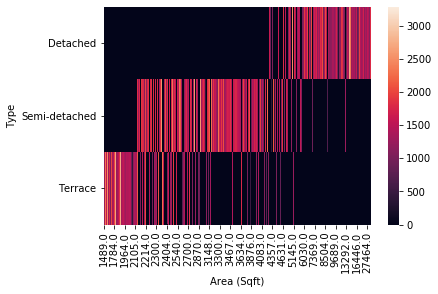

In [35]:
sns.heatmap(landed_sfp)

### Predictions
Using Machine Learning techniques to try to obtain metries such as:
- Accuracy
- MSE

Depending on method used

In [ ]:
%%bash
## installs necessary libraries for work below
!pip install sklearn

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# preprocessing
def split_X_and_y(df):
    '''
        - preprocessing is done here
        - returns processed X and y values
    '''
    df = df.dropna()  # there should b a better way of handling NA valus but I LAZY
    
    # 1. seperate labels from predictors
    y = df[df.columns[14]]  #Unit price per sq foot
    cols_to_remove = df.columns[[0,9,10,13,14]]
    X = df.drop(cols_to_remove, axis=1)
    
    # 2. encode data fit for prediction
    X_num = X.iloc[:,[7,8]]
    categorical_var = X.drop(["No. of Units", "Area (Sqft)"], axis=1)

    X_cat = pd.get_dummies(categorical_var)
    X = pd.concat([X_cat, X_num], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

from sklearn.model_selection import GridSearchCV
def train_data(estimator, params, X_train, y_train):
    ## import the sklearn libraries first
    reg_grid = GridSearchCV(estimator, params)
    reg_grid.fit(X_train, y_train)
    
    return reg_grid.best_estimator_
    

In [108]:
X_train, X_test, y_train, y_test = split_X_and_y(landed)

In [109]:
sum(X_train.isna().iloc[:,6])

0

In [110]:
from sklearn.linear_model import Lasso
best_reg = train_data(estimator=Lasso(),
                     params={
                         'alpha': [0.5,1],
                         'normalize' : [True, False],
                         'max_iter': [200, 500, 1000, 10000],
                         'warm_start' : [True, False]
                     },
                     X_train=X_train,
                     y_train=y_train)

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2164681.303028632, tolerance: 9552.54064231537
  positive)
c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2016181.1567478143, tolerance: 10139.614333333333
  positive)
c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2330274.8713892847, tolerance: 10497.877685258964
  positive)
c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent

c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222237.40231450275, tolerance: 10477.63292749004
  positive)
c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 741850.2936997339, tolerance: 9552.54064231537
  positive)
c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 663934.2700739726, tolerance: 10139.614333333333
  positive)
c:\users\ivanl\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

In [113]:
from sklearn.metrics import mean_squared_error, r2_score
preds = best_reg.predict(X_test)
metrics = {
    'mse': mean_squared_error(preds , y_test),
    'rSquared' : r2_score(preds, y_test)
}

metrics

{'mse': 102733.52728266607, 'rSquared': -0.25659047002398094}

Well it's obvious that it would fit bad LOL